Задание:
Решить задачу машинного перевода выбрав свой язык:
- Формируем датасет с исходного языка на целевой (код прописать в классе)
- Строим архитектуру нейронной сети 
- Обучаем 
- Проверить качество с помощью метрики BLEU

## Формирование датасета

In [1]:
import os
import re
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from typing import List
from torch.cuda.amp import GradScaler

Зададим воспроизводимость результатов псевдослучайной генерации

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Определяем настройки

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64  
N_EPOCHS = 30
CLIP = 1
EMB_DIM = 512
HIDDEN_DIM = 1024
LEARNING_RATE = 0.0005
MAX_SEQUENCE_LENGTH = 100  # Ограничение длины последовательности
MAX_SAMPLES = 5000  # Уменьшенный размер выборки для экономии памяти

Используем смешанную точность для экономии памяти

In [4]:
scaler = torch.amp.GradScaler()

Определим методы для предобработки текста

In [5]:
# Приведение текста к нижнему регистру и удаление пунктуации

def preprocess_text(text: str) -> str:
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [6]:
#  Обрезка длины последовательности до max_length

def truncate_sequence(sequence: List[int], max_length: int = MAX_SEQUENCE_LENGTH):
    if len(sequence) > max_length:
        return sequence[:max_length]
    return sequence

In [7]:
# Построение словаря из токенов

# <PAD>: Используется для дополнения последовательностей до одинаковой длины.
# <SOS>: Начальный токен (Start Of Sequence).
# <EOS>: Конечный токен (End Of Sequence).
# <UNK>: Токен для неизвестных слов (Unknown)

def build_vocab(sentences: List[str], reserved_tokens: List[str] = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]) -> dict:
    # Создаем словарь, инициализируя его зарезервированными токенами с их индексами
    vocab = {token: idx for idx, token in enumerate(reserved_tokens)}
    current_index = len(vocab)  # Устанавливаем текущий индекс для новых слов, начиная с конца зарезервированных токенов
    
    # Проходим по каждому предложению в списке предложений
    for sentence in sentences:
        # Разделяем предложение на слова
        for word in sentence.split():
            # Если слово еще не в словаре, добавляем его с текущим индексом
            if word not in vocab:
                vocab[word] = current_index
                current_index += 1  # Увеличиваем индекс для следующего слова
    
    return vocab  # Возвращаем построенный словарь

In [8]:
# Токенизация предложения: добавление токенов <SOS> и <EOS>

def tokenize_sentence(sentence: str, vocab: dict, sos_token="<SOS>", eos_token="<EOS>") -> List[int]:
    # Создаем список токенов, начиная с токена начала последовательности (sos_token)
    # Затем добавляем токены для каждого слова в предложении, используя словарь vocab
    # Если слово не найдено в словаре, используем токен для неизвестных слов (<UNK>)
    tokens = [vocab[sos_token]] + [vocab.get(word, vocab["<UNK>"]) for word in sentence.split()] + [vocab[eos_token]]
    
    return tokens  # Возвращаем список токенов, включая <SOS> и <EOS>

Опишем датасет в классе

In [9]:
class TranslationDataset(Dataset):
    def __init__(self, source_sentences: List[str], target_sentences: List[str], source_vocab: dict, target_vocab: dict):
        # Инициализация объекта TranslationDataset с исходными и целевыми предложениями и соответствующими словарями
        self.source_sentences = source_sentences  # Список исходных предложений
        self.target_sentences = target_sentences  # Список целевых предложений
        self.source_vocab = source_vocab  # Словарь для преобразования исходных предложений в токены
        self.target_vocab = target_vocab  # Словарь для преобразования целевых предложений в токены

    def __len__(self):
        # Возвращает количество предложений в наборе данных
        return len(self.source_sentences)

    def __getitem__(self, idx):
        # Получает токенизированные и обрезанные исходное и целевое предложения по индексу
        source = truncate_sequence(tokenize_sentence(self.source_sentences[idx], self.source_vocab))
        target = truncate_sequence(tokenize_sentence(self.target_sentences[idx], self.target_vocab))
        
        # Возвращает исходное и целевое предложения в виде тензоров типа long
        return torch.tensor(source, dtype=torch.long), torch.tensor(target, dtype=torch.long)

Определим функцию для обработки батчей

In [10]:
def collate_fn(batch):
    # Разделяем батч на списки исходных и целевых последовательностей
    sources, targets = zip(*batch)
    
    # Паддинг исходных последовательностей до одинаковой длины с использованием значения <PAD> = 0
    source_padded = torch.nn.utils.rnn.pad_sequence(sources, batch_first=True, padding_value=0)  # <PAD> = 0
    
    # Паддинг целевых последовательностей до одинаковой длины с использованием значения <PAD> = 0
    target_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=0)
    
    # Возвращаем паддированные исходные и целевые последовательности
    return source_padded, target_padded

## Строим архитектуру нейронной сети

###  Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, emb_dim: int, hidden_dim: int, dropout: float = 0.3):
        # Инициализация объекта Encoder
        super(Encoder, self).__init__()
        
        # Эмбеддинг для преобразования входных токенов в векторы фиксированной размерности
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        # LSTM-слой для обработки последовательностей
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        
        # Слой дропаута для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # Применяем эмбеддинг и дроп-аут к входным данным
        embedded = self.dropout(self.embedding(src))
        
        # Пропускаем эмбеддинги через LSTM и получаем скрытое состояние и ячейку
        _, (hidden, cell) = self.rnn(embedded)
        
        # Возвращаем скрытое состояние и ячейку для последующего декодирования
        return hidden, cell

### Decoder

In [12]:
class Decoder(nn.Module):
    def __init__(self, output_dim: int, emb_dim: int, hidden_dim: int, dropout: float = 0.3):
        # Инициализация объекта Decoder
        super(Decoder, self).__init__()
        
        # Эмбеддинг для преобразования выходных токенов в векторы фиксированной размерности
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # LSTM-слой для обработки последовательностей
        self.rnn = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        
        # Полносвязный слой для преобразования выходного скрытого состояния в размерность выходных токенов
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Слой дропаута для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, hidden):
        # Применяем эмбеддинг и дроп-аут к входным данным
        embedded = self.dropout(self.embedding(trg))
        
        # Пропускаем эмбеддинги через LSTM и получаем выход и обновленное скрытое состояние
        output, (hidden, cell) = self.rnn(embedded, hidden)
        
        # Применяем полносвязный слой к выходу LSTM для получения предсказаний
        output = self.fc(output)
        
        # Возвращаем выход и обновленное скрытое состояние и ячейку
        return output, (hidden, cell)

### Seq2Seq модель

In [13]:
class Seq2Seq(nn.Module):
    # Инициализация класса Seq2Seq
    def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder  # Инициализация кодировщика
        self.decoder = decoder  # Инициализация декодировщика
        self.device = device  # Устройство (CPU или GPU), на котором будет выполняться модель
 
    # Метод прямого прохода (forward) для модели Seq2Seq
    def forward(self, src, trg, teacher_forcing_ratio: float = 0.5):
        src = src.to(self.device)  # Перемещение входных данных (src) на нужное устройство
        trg = trg.to(self.device)  # Перемещение целевых данных (trg) на нужное устройство
        batch_size, trg_len = trg.size()  # Получаем размер пакета и длину целевых последовательностей
        output_dim = self.decoder.fc.out_features  # Получаем размер выходного слоя декодировщика
        outputs = torch.zeros(batch_size, trg_len, output_dim, device=self.device)  # Инициализация тензора для хранения выходов

        hidden, cell = self.encoder(src)  # Получаем скрытые состояния и ячейки от кодировщика
        input = trg[:, 0]  # Устанавливаем первый токен (обычно <SOS>) в качестве входа для декодера

        # Проходим по всем временным шагам целевой последовательности
        for t in range(1, trg_len):
            # Выполняем шаг декодирования
            output, (hidden, cell) = self.decoder(input.unsqueeze(1), (hidden, cell))
            outputs[:, t, :] = output.squeeze(1)  # Сохраняем выход декодера в тензор outputs

            # Определяем, использовать ли teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            # Если используем teacher forcing, берем следующий токен из целевой последовательности, иначе - предсказанный токен
            input = trg[:, t] if teacher_force else output.argmax(2).squeeze(1)

        return outputs  # Возвращаем все выходные данные декодера

## Обучаем модель

In [14]:
def train_with_amp(model: Seq2Seq, iterator: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, clip: float):
    # Устанавливаем модель в режим обучения
    model.train()
    epoch_loss = 0  # Инициализируем переменную для хранения потерь за эпоху

    # Проходим по данным в итераторе (пакетам)
    for src, trg in iterator:
        src, trg = src.to(model.device), trg.to(model.device)  # Перемещаем данные на нужное устройство (GPU/CPU)

        optimizer.zero_grad()  # Обнуляем градиенты оптимизатора перед новой итерацией

        # Используем автоматическое смешивание точности (AMP) для повышения производительности
        with torch.amp.autocast(device_type='cuda'):
            output = model(src, trg)  # Получаем выход модели
            output_dim = output.shape[-1]  # Получаем размер выходного слоя
            trg = trg[:, 1:].reshape(-1)  # Убираем токен начала последовательности и изменяем форму целевых данных
            output = output[:, 1:].reshape(-1, output_dim)  # Убираем токен начала последовательности из выходов

            loss = criterion(output, trg)  # Вычисляем потери

        # Масштабируем потери и выполняем обратное распространение
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)  # Отменяем масштабирование градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # Обрезаем градиенты для предотвращения их разрастания
        scaler.step(optimizer)  # Обновляем параметры модели
        scaler.update()  # Обновляем масштабирование для следующей итерации

        epoch_loss += loss.item()  # Суммируем потери за эпоху

    # Возвращаем средние потери за эпоху
    return epoch_loss / len(iterator)

## Оценка модели

In [15]:

def evaluate(model: Seq2Seq, iterator: DataLoader, criterion: nn.Module):
    # Устанавливаем модель в режим оценки
    model.eval()
    epoch_loss = 0  # Инициализируем переменную для хранения потерь за эпоху
    predictions, references = [], []  # Списки для хранения предсказаний и эталонных значений
    smoothing_function = SmoothingFunction().method4  # Функция сглаживания для BLEU

    # Отключаем вычисление градиентов для экономии памяти
    with torch.no_grad():
        # Проходим по данным в итераторе (пакетам)
        for src, trg in iterator:
            # Перемещаем данные на устройство (GPU/CPU)
            src, trg = src.to(model.device), trg.to(model.device)

            # Получаем предсказания модели, отключая teacher forcing
            output = model(src, trg, teacher_forcing_ratio=0.0)
            # Находим индексы токенов с максимальной вероятностью
            preds = output.argmax(2).cpu().tolist()  # Переводим на CPU и в список
            trg = trg.cpu().tolist()  # Также переводим целевые данные на CPU и в список

            # Обрабатываем предсказания и эталонные значения
            for pred, ref in zip(preds, trg):
                # Убираем заполнители (токены с индексом 0) из предсказаний и эталонов
                pred = [token for token in pred if token != 0]
                ref = [token for token in ref if token != 0]
                # Если эталонное значение не пустое, добавляем его в списки
                if len(ref) > 0:
                    predictions.append(pred)
                    references.append([ref])  # Добавляем эталон в формате списка

            # Подготавливаем данные для расчета потерь
            trg = torch.tensor(trg, device=model.device)  # Переводим целевые данные обратно в тензор
            trg = trg[:, 1:].reshape(-1)  # Убираем токен начала последовательности и изменяем форму
            output = output[:, 1:].reshape(-1, output.shape[-1])  # Убираем токен начала последовательности из выходов

            # Вычисляем потери
            loss = criterion(output, trg)
            epoch_loss += loss.item()  # Суммируем потери за эпоху

    # Вычисляем BLEU-оценку для предсказаний
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothing_function)
    # Возвращаем средние потери за эпоху и BLEU-оценку
    return epoch_loss / len(iterator), bleu_score


## Проверяем качество модели 

Загружаем данные 

In [16]:
# Загружаем датасет opus100 из Hugging Face
dataset = load_dataset("opus100", "en-ru")

# Предобрабатываем английские предложения и выбираем первые MAX_SAMPLES
source_sentences = [preprocess_text(item["translation"]["en"]) for item in dataset["train"]][:MAX_SAMPLES]

# Предобрабатываем русские предложения и выбираем первые MAX_SAMPLES
target_sentences = [preprocess_text(item["translation"]["ru"]) for item in dataset["train"]][:MAX_SAMPLES]

# Создаем словарь для английских предложений на основе предобработанных данных
source_vocab = build_vocab(source_sentences)

# Создаем словарь для русских предложений на основе предобработанных данных
target_vocab = build_vocab(target_sentences)

# Разделяем данные на обучающую и валидационную выборки (80% на обучение, 20% на валидацию)
train_src, val_src, train_trg, val_trg = train_test_split(source_sentences, target_sentences, test_size=0.2)

# Создаем обучающий датасет для перевода с использованием предобработанных предложений и словарей
train_dataset = TranslationDataset(train_src, train_trg, source_vocab, target_vocab)

# Создаем валидационный датасет для перевода с использованием предобработанных предложений и словарей
val_dataset = TranslationDataset(val_src, val_trg, source_vocab, target_vocab)

# Создаем загрузчик данных для обучающего датасета с заданным размером пакета и перемешиванием данных
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# Создаем загрузчик данных для валидационного датасета с заданным размером пакета
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

Модель

In [17]:
# Создаем экземпляр энкодера с размером входного словаря, размером эмбеддинга и размером скрытого состояния
encoder = Encoder(len(source_vocab), EMB_DIM, HIDDEN_DIM).to(DEVICE)

# Создаем экземпляр декодера с размером выходного словаря, размером эмбеддинга и размером скрытого состояния
decoder = Decoder(len(target_vocab), EMB_DIM, HIDDEN_DIM).to(DEVICE)

# Создаем модель Seq2Seq, передавая в нее энкодер и декодер, а также устройство (GPU/CPU)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

# Настраиваем оптимизатор Adam для модели с заданной скоростью обучения и весом распада
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)  # Значение weight_decay можно настроить для регуляризации

# Определяем функцию потерь - кросс-энтропия, игнорируя индекс 0 (обычно используется для паддинга)
criterion = nn.CrossEntropyLoss(ignore_index=0)

Обучаем модель

In [18]:
# Инициализируем списки для хранения значений потерь на обучающем и валидационном наборах, а также для BLEU-оценок
train_losses, val_losses, bleu_scores = [], [], []

# Запускаем цикл обучения на заданное количество эпох
for epoch in range(N_EPOCHS):
    torch.cuda.empty_cache()  # Очищаем кэш GPU для предотвращения переполнения памяти

    # Обучаем модель на текущей эпохе с использованием автоматического смешанного точности (AMP) для повышения производительности
    train_loss = train_with_amp(model, train_loader, optimizer, criterion, CLIP)  # CLIP используется для ограничения (или обрезки) градиентов во время обучения модели
    
    # Оцениваем модель на валидационном наборе данных и получаем значение потерь и BLEU-оценку
    val_loss, bleu = evaluate(model, val_loader, criterion)

    # Сохраняем значения потерь и BLEU-оценок для текущей эпохи
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    bleu_scores.append(bleu)

    # Выводим результаты текущей эпохи в консоль
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | BLEU: {bleu:.4f}")


Epoch 1 | Train Loss: 7.8751 | Val Loss: 7.6200 | BLEU: 0.0001
Epoch 2 | Train Loss: 7.2997 | Val Loss: 7.6273 | BLEU: 0.0001
Epoch 3 | Train Loss: 7.1900 | Val Loss: 7.6288 | BLEU: 0.0001
Epoch 4 | Train Loss: 7.0990 | Val Loss: 7.6698 | BLEU: 0.0002
Epoch 5 | Train Loss: 7.0281 | Val Loss: 7.6814 | BLEU: 0.0001
Epoch 6 | Train Loss: 6.9397 | Val Loss: 7.6710 | BLEU: 0.0001
Epoch 7 | Train Loss: 6.8439 | Val Loss: 7.6587 | BLEU: 0.0002
Epoch 8 | Train Loss: 6.7294 | Val Loss: 7.6383 | BLEU: 0.0002
Epoch 9 | Train Loss: 6.6137 | Val Loss: 7.6490 | BLEU: 0.0002
Epoch 10 | Train Loss: 6.5032 | Val Loss: 7.6530 | BLEU: 0.0002
Epoch 11 | Train Loss: 6.3943 | Val Loss: 7.6469 | BLEU: 0.0003
Epoch 12 | Train Loss: 6.2991 | Val Loss: 7.6477 | BLEU: 0.0002
Epoch 13 | Train Loss: 6.1838 | Val Loss: 7.6454 | BLEU: 0.0002
Epoch 14 | Train Loss: 6.1013 | Val Loss: 7.6500 | BLEU: 0.0005
Epoch 15 | Train Loss: 5.9952 | Val Loss: 7.6541 | BLEU: 0.0002
Epoch 16 | Train Loss: 5.9380 | Val Loss: 7.6714 

1. Train Loss: Значение Train Loss постепенно уменьшается с каждой эпохой, модель обучается и улучшает свои предсказания на тренировочных данных.

2. Val Loss: Значения Val Loss колеблются, но в целом остаются на высоком уровне. В начале обучения (эпохи 1-10) Val Loss сначала понижается, но затем начинает расти и колебаться вокруг значения 7.6-7.7. Это может указывать на то, что модель начинает переобучаться, так как Train Loss продолжает снижаться, а Val Loss не показывает стабильного улучшения. Хотя мы ввели и drop out, и L2 регуляризации.

3. BLEU Score: Значения BLEU остаются невысокими в течение всего обучения, начиная с 0.0001 и достигая 0.0016 к 30-й эпохе. Это говорит о том, что качество предсказаний модели по сравнению с реальными данными остается низким.

Строим графики

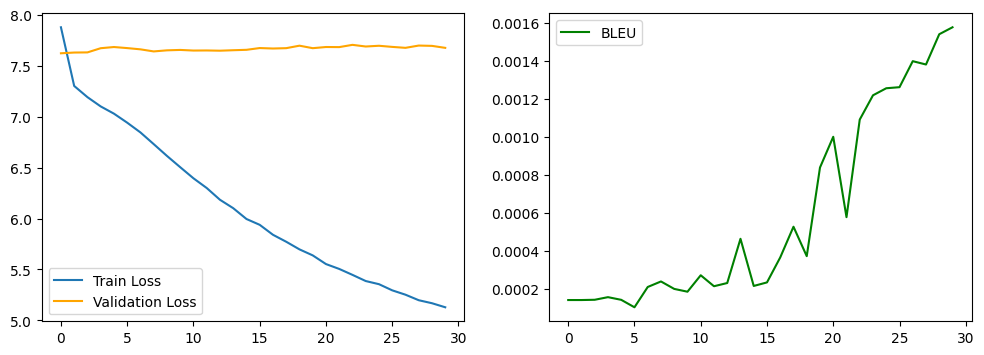

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(bleu_scores, label="BLEU", color="green")
plt.legend()
plt.show()

Выводы:
1. Настройка гиперпараметров: Возможно, стоит провести настройку гиперпараметров, таких как скорость обучения или архитектура модели. Это может помочь улучшить результаты на валидационных данных.

2. Проблемы с данными: Если BLEU Score остается низким, возможно, стоит рассмотреть возможность увеличения объема данных или улучшения их качества, однако в условиях домашки не представляется возможным..

3. В целом, результаты показывают, что модель обучается, но качество предсказаний остается не высоким. Необходимо провести дополнительные эксперименты и анализ, чтобы улучшить производительность модели.